# Brazilian E-commerce Data Analysis

This notebook contains a comprehensive analysis of the Brazilian E-commerce dataset from Olist.

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Set style for better visualization
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

In [4]:
import os
import sys

# Add the project root directory to Python path
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

from src.utils.data_loader import load_all_datasets
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for visualizations
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Load all datasets
try:
    data = load_all_datasets()
    print("Successfully loaded all datasets")
except Exception as e:
    print(f"Error loading datasets: {str(e)}")

# Access individual datasets
sellers = data['sellers']
customers = data['customers']
orders = data['orders']
products = data['products']
order_items = data['order_items']
order_payments = data['order_payments']
reviews = data['reviews']
category_translation = data['category_translation']

Successfully loaded all datasets


## 1. Sellers Analysis

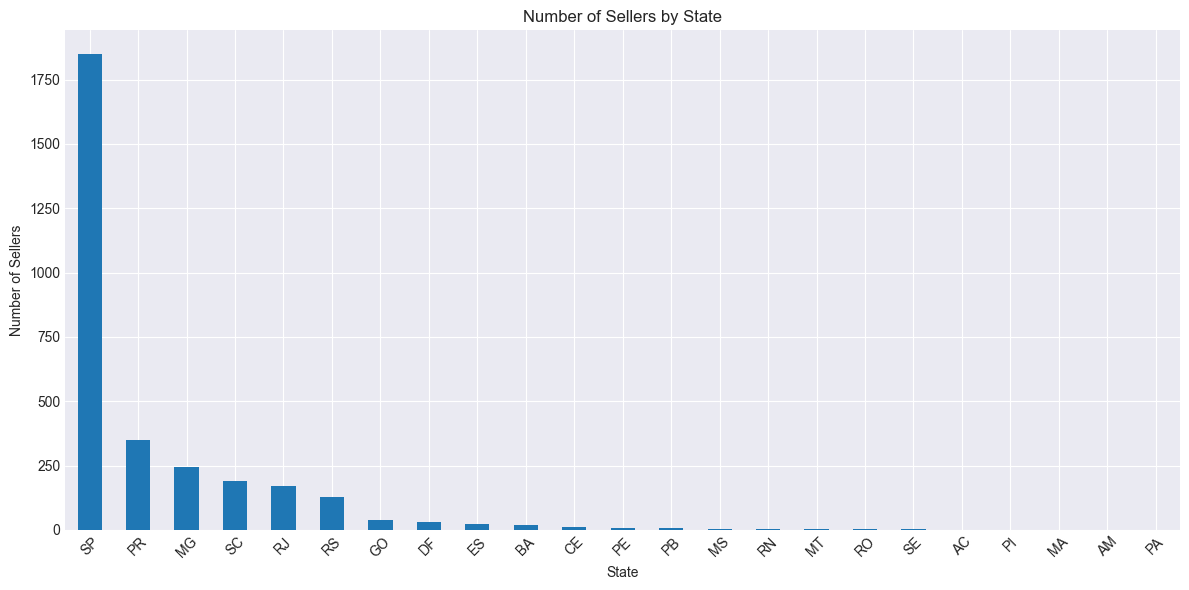

In [5]:
plt.figure(figsize=(12, 6))
sellers_by_state = sellers['seller_state'].value_counts()
sellers_by_state.plot(kind='bar')
plt.title('Number of Sellers by State')
plt.xlabel('State')
plt.ylabel('Number of Sellers')
plt.xticks(rotation=45)
plt.tight_layout()

## 2. Products Analysis

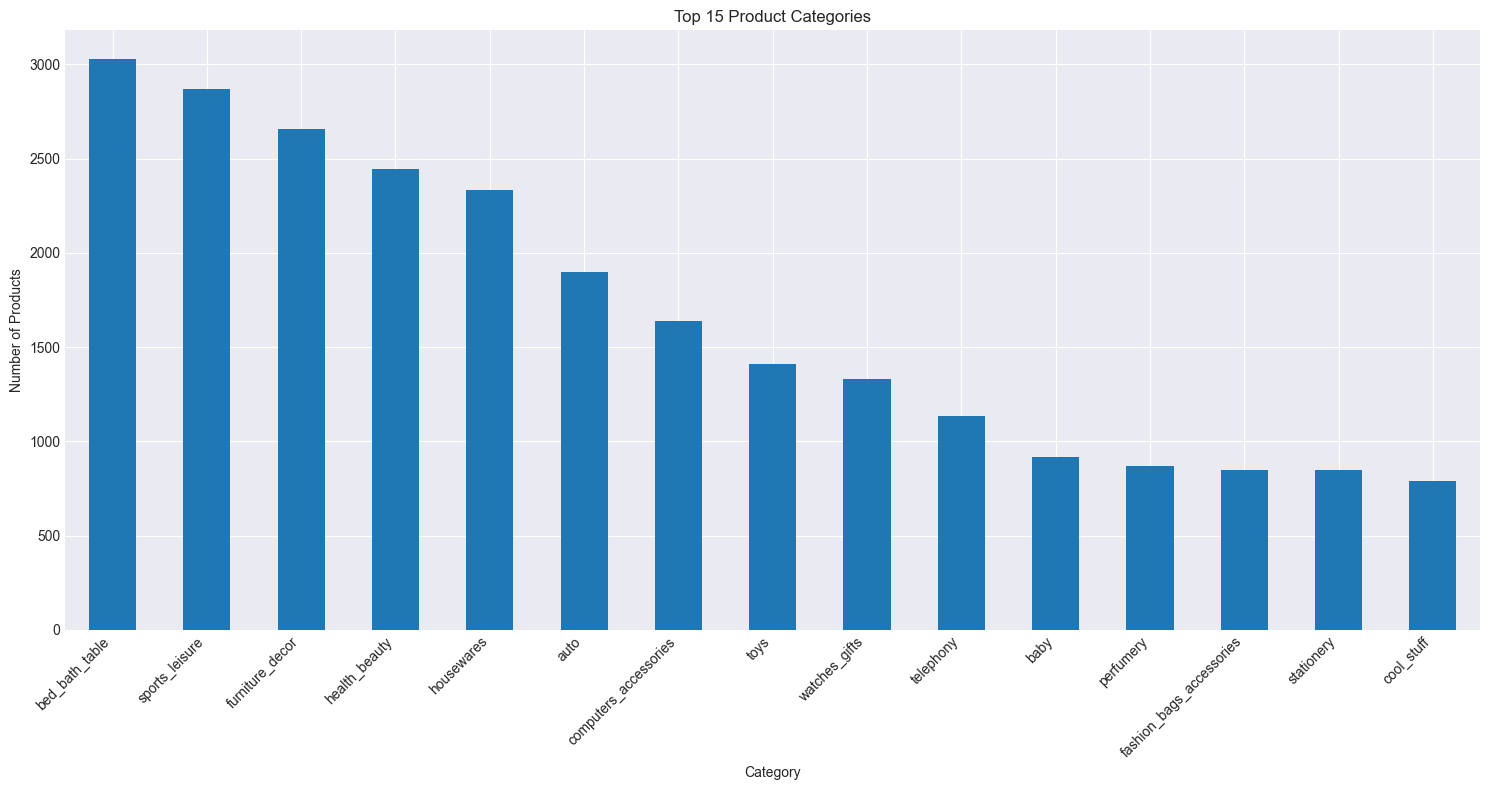

In [6]:
# Merge with translation table
products = products.merge(category_translation, on='product_category_name', how='left')
plt.figure(figsize=(15, 8))
top_categories = products['product_category_name_english'].value_counts().head(15)
top_categories.plot(kind='bar')
plt.title('Top 15 Product Categories')
plt.xlabel('Category')
plt.ylabel('Number of Products')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

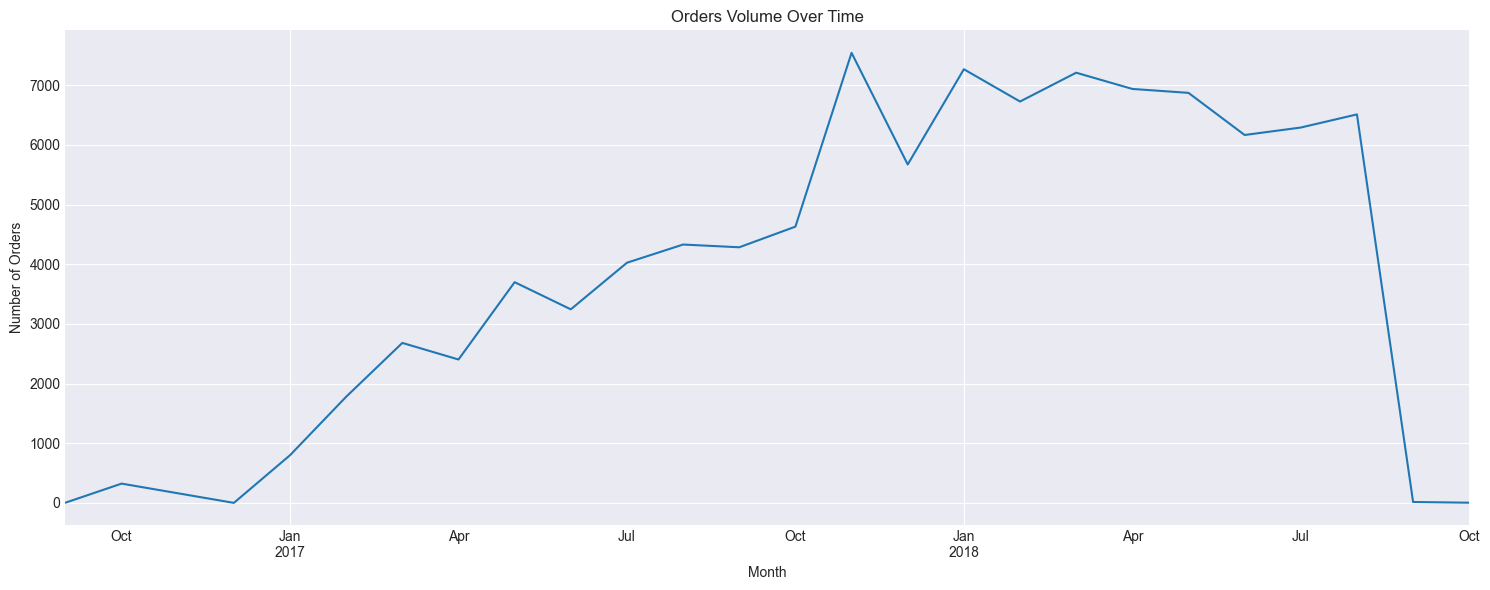

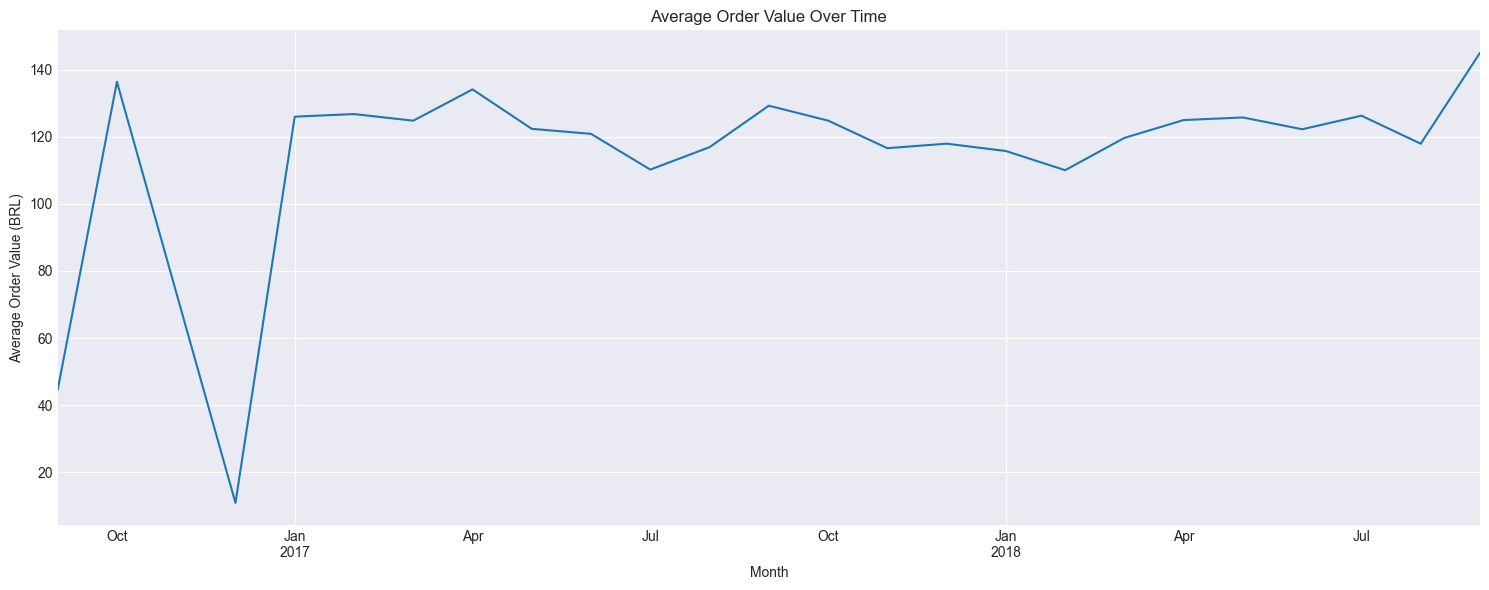

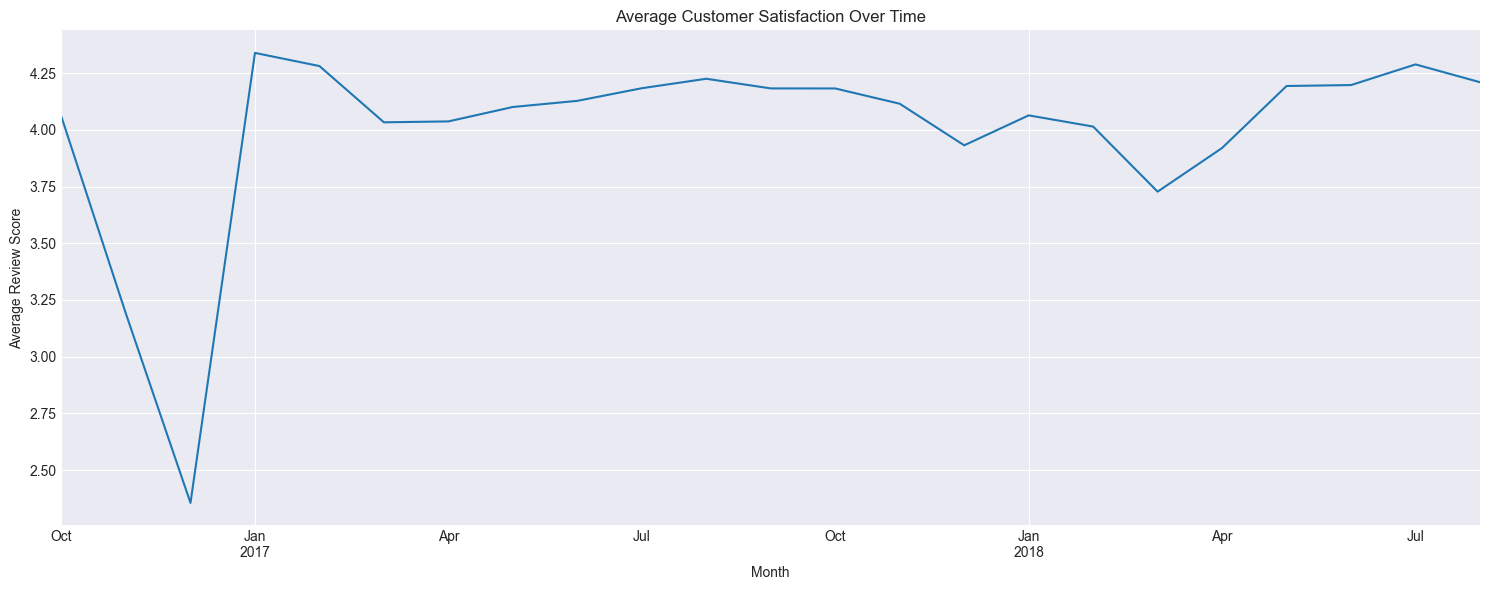

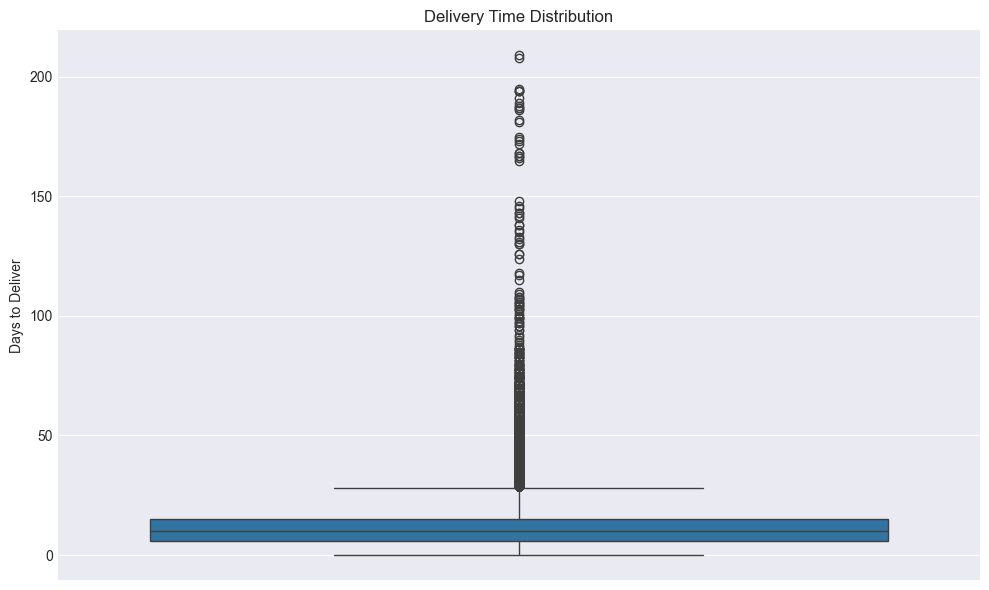

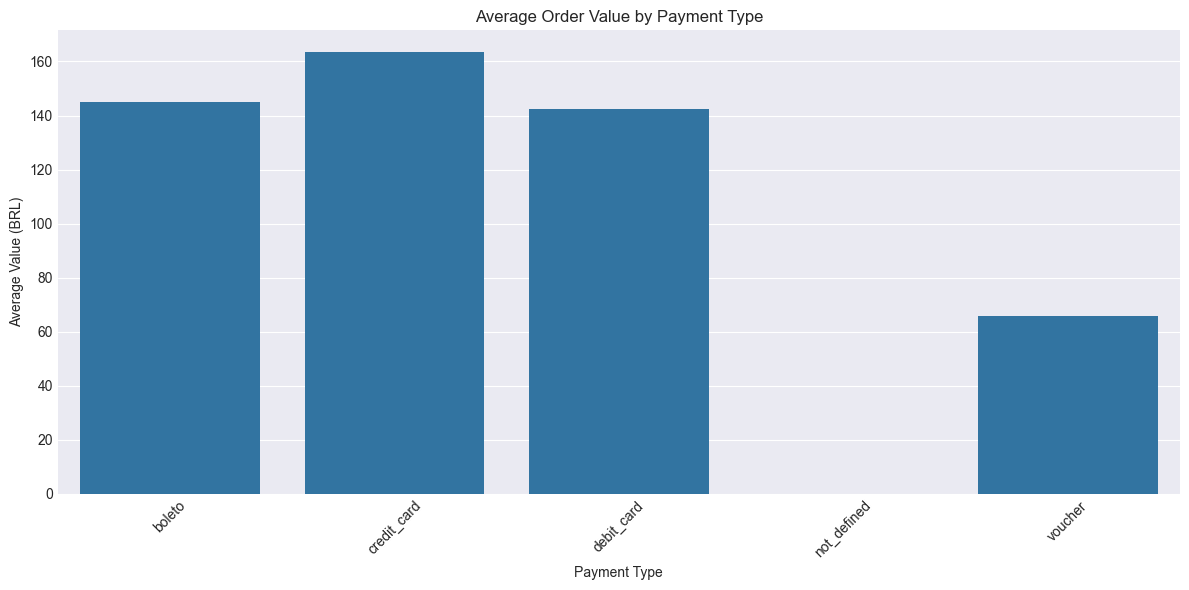

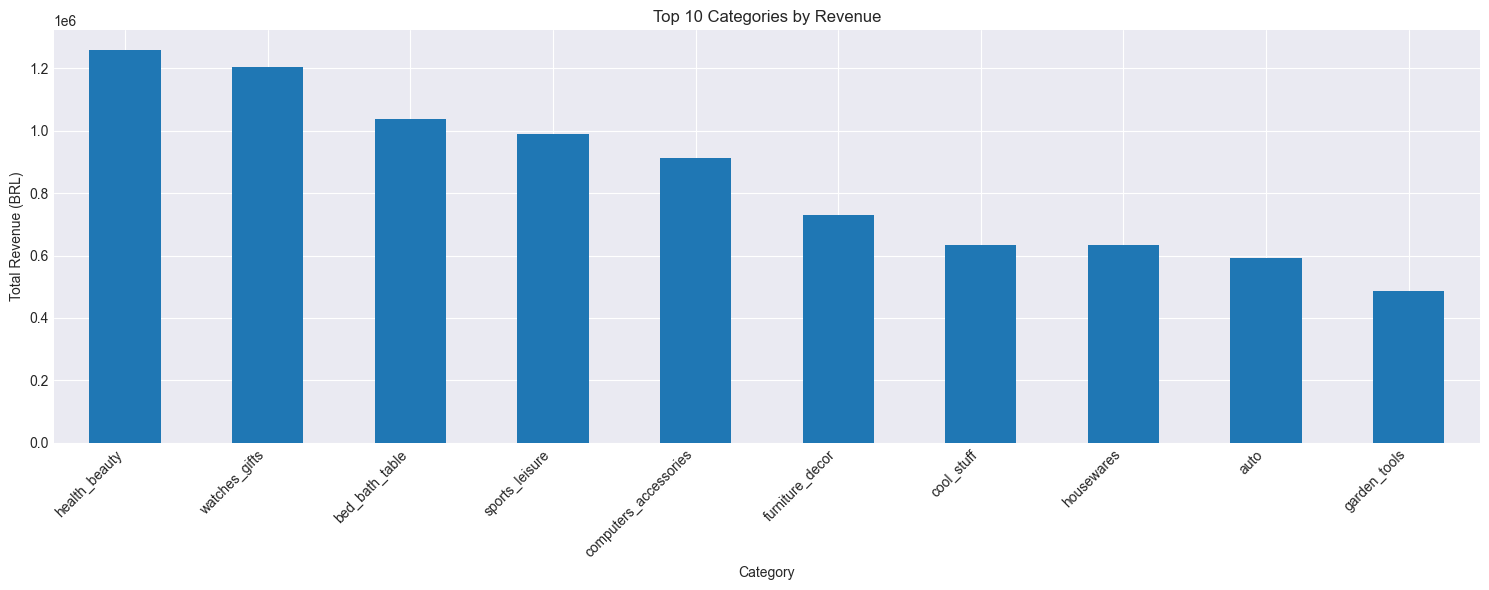

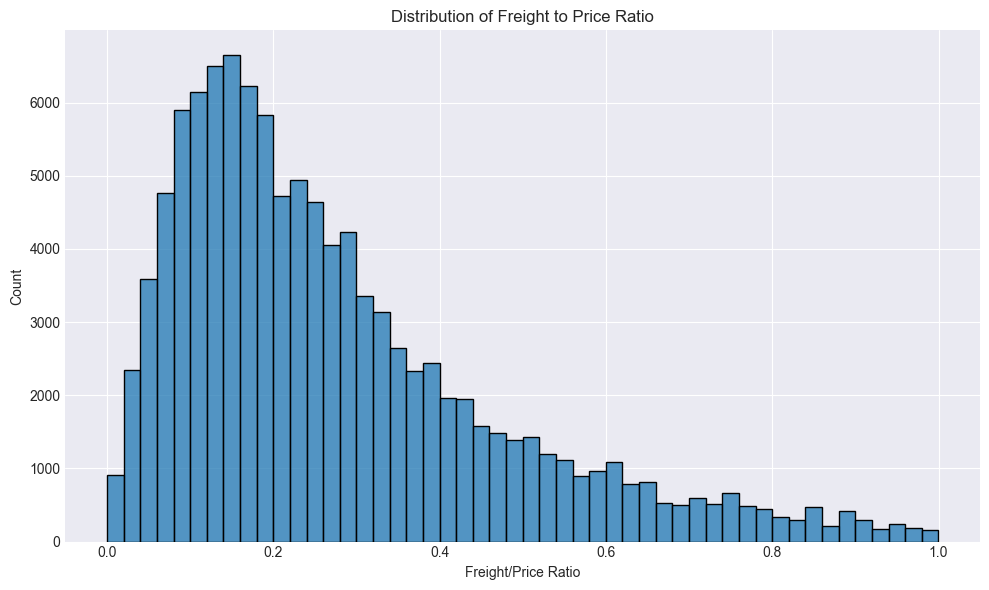

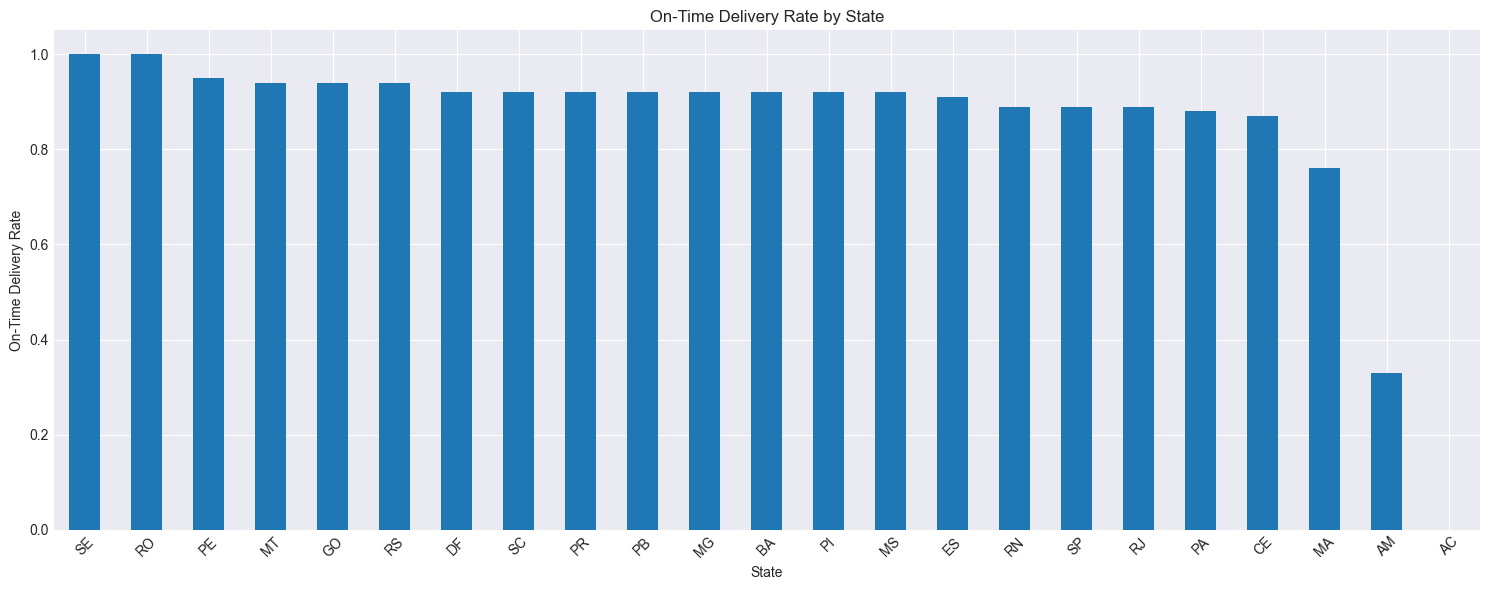

In [ ]:
# Additional time-based analysis
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['month_year'] = orders['order_purchase_timestamp'].dt.to_period('M')

# Orders per month
plt.figure(figsize=(15, 6))
orders.groupby('month_year').size().plot(kind='line')
plt.title('Orders Volume Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.tight_layout()

# Average order value over time
monthly_avg_order = order_items.merge(orders[['order_id', 'month_year']], on='order_id')\
    .groupby('month_year')['price'].mean()

plt.figure(figsize=(15, 6))
monthly_avg_order.plot(kind='line')
plt.title('Average Order Value Over Time')
plt.xlabel('Month')
plt.ylabel('Average Order Value (BRL)')
plt.tight_layout()

# Customer satisfaction analysis
reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'])
monthly_satisfaction = reviews.groupby(reviews['review_creation_date'].dt.to_period('M'))['review_score'].mean()

plt.figure(figsize=(15, 6))
monthly_satisfaction.plot(kind='line')
plt.title('Average Customer Satisfaction Over Time')
plt.xlabel('Month')
plt.ylabel('Average Review Score')
plt.tight_layout()

# Payment analysis
payment_value_by_type = order_payments.groupby('payment_type')['payment_value'].agg(['mean', 'count', 'sum'])

plt.figure(figsize=(12, 6))
sns.barplot(x=payment_value_by_type.index, y=payment_value_by_type['mean'])
plt.title('Average Order Value by Payment Type')
plt.xlabel('Payment Type')
plt.ylabel('Average Value (BRL)')
plt.xticks(rotation=45)
plt.tight_layout()

# Product categories deeper analysis
category_metrics = (
    order_items.merge(products[['product_id', 'product_category_name_english']], on='product_id')
    .groupby('product_category_name_english')
    .agg({
        'order_id': 'count',
        'price': ['mean', 'sum'],
        'freight_value': 'mean'
    })
)

# Top 10 categories by revenue
plt.figure(figsize=(15, 6))
category_metrics[('price', 'sum')].sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Categories by Revenue')
plt.xlabel('Category')
plt.ylabel('Total Revenue (BRL)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Freight analysis
freight_ratio = order_items['freight_value'] / order_items['price']
plt.figure(figsize=(10, 6))
sns.histplot(freight_ratio[freight_ratio < 1], bins=50)
plt.title('Distribution of Freight to Price Ratio')
plt.xlabel('Freight/Price Ratio')
plt.ylabel('Count')
plt.tight_layout()

# Seller performance metrics
seller_metrics = order_items.merge(orders[['order_id', 'order_delivered_customer_date', 'order_estimated_delivery_date']], 
                                 on='order_id').merge(sellers[['seller_id', 'seller_state']], on='seller_id')

seller_metrics['on_time_delivery'] = pd.to_datetime(seller_metrics['order_delivered_customer_date']) <= \
                                   pd.to_datetime(seller_metrics['order_estimated_delivery_date'])

# Performance by state
state_performance = seller_metrics.groupby('seller_state').agg({
    'on_time_delivery': 'mean',
    'order_id': 'count',
    'price': ['mean', 'sum']
}).round(2)

plt.figure(figsize=(15, 6))
state_performance['on_time_delivery']['mean'].sort_values(ascending=False).plot(kind='bar')
plt.title('On-Time Delivery Rate by State')
plt.xlabel('State')
plt.ylabel('On-Time Delivery Rate')
plt.xticks(rotation=45)
plt.tight_layout()